Processing file: /pscratch/sd/j/jspiller/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2/A/modified_minsignal2_desi_bright_qso_batch42.fits
158/158 [==============================] - 5s 16ms/step - loss: 0.3523 - accuracy: 0.8959 - f1_metric: 0.0014 - auc: 0.5127 - val_loss: 0.3219 - val_accuracy: 0.9021 - val_f1_metric: 0.0000e+00 - val_auc: 0.4968
Epoch 1: AUC = 0.4968014061450958
158/158 [==============================] - 2s 10ms/step - loss: 0.3325 - accuracy: 0.9007 - f1_metric: 0.0000e+00 - auc: 0.4744 - val_loss: 0.3214 - val_accuracy: 0.9021 - val_f1_metric: 0.0000e+00 - val_auc: 0.4942
Epoch 2: AUC = 0.4941725730895996
Best Epoch: 1, Best AUC: 0.4968014061450958
Saved best weights to: best_weights_Class_lr_20_test.h5
158/158 [==============================] - 1s 3ms/step


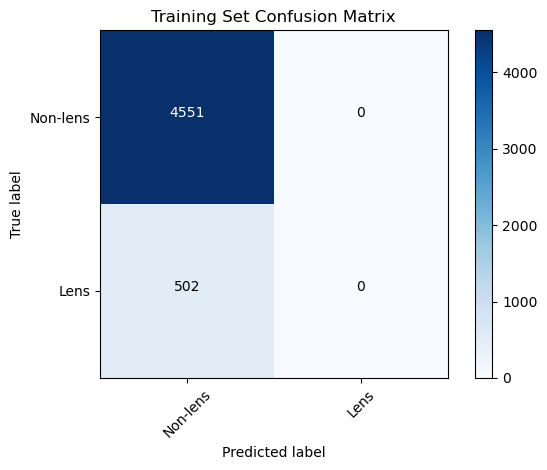

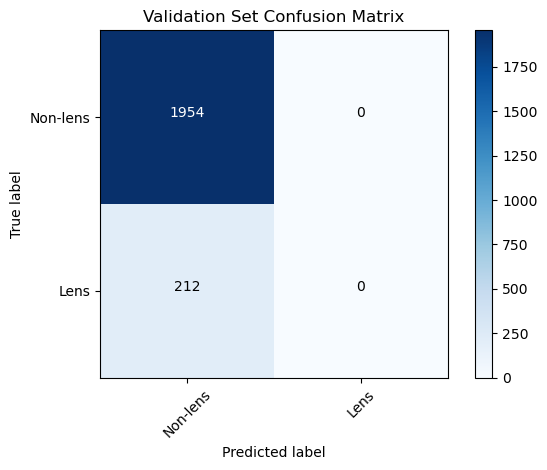

Saved config to: Config/Config0/custom_config0.json


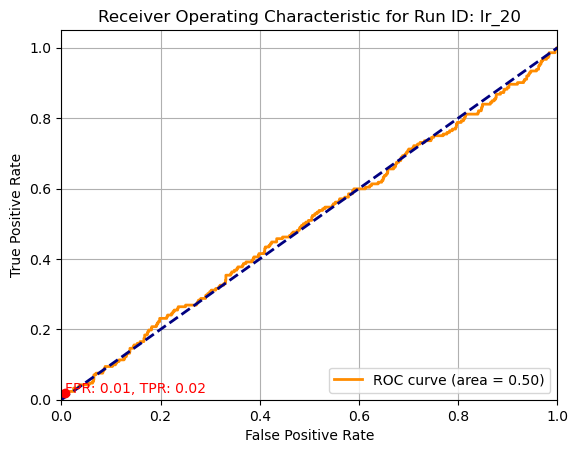

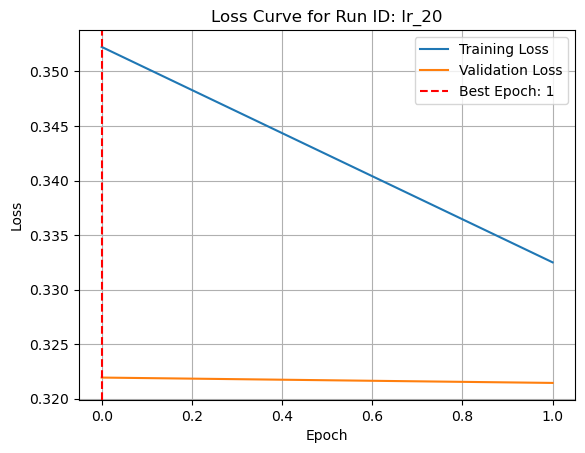

Number of labels = 1 in training set: 502


In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
import fitsio

# Global variable to keep track of runs
global_counter = 0

def extract_data_from_fits(file_path):
    with fitsio.FITS(file_path) as hdul:
        target_ids = hdul[1]['TARGETID'][:]
        redshifts = hdul[1]['Z'][:]
        flux = hdul[1]['FLUX'][:]
        labels = hdul[1]['LABEL'][:]
    return flux, labels

def save_config(lr, do, bs, input_layer, n_node_CNN, n_node_FC, count):
    config_dict = {'lr': lr, 'do': do, 'bs': bs, 'input_layer': input_layer, 'n_node_CNN': n_node_CNN, 'n_node_FC': n_node_FC}

    directory_path = f'Config/Config{count}/'

    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    file_path = os.path.join(directory_path, f'custom_config{count}.json')
    with open(file_path, 'w') as json_file:
        json.dump(config_dict, json_file)
        print('Saved config to:', file_path)

def f1_metric(y_true, y_pred):
    # Round the predictions
    y_pred = tf.round(y_pred)
    
    # Define a wrapper function for f1_score with zero_division handling
    def f1_score_custom(y_true, y_pred):
        y_true = y_true.numpy()  # Convert tensor to numpy array
        y_pred = y_pred.numpy()
        return f1_score(y_true, y_pred, zero_division=0)

    # Use tf.py_function to call the f1_score_custom
    f1_value = tf.py_function(f1_score_custom, [y_true, y_pred], tf.double)
    return f1_value

def decode(y):
    return np.asarray([1. if yi > 0.5 else 0. for yi in y])

def network(X_train, X_valid, y_train, y_valid, lr, do, bs, runid, input_layer, n_node_CNN, n_node_FC, weights_path=None, plot_conf_matrix=True, use_lr_decay=True):
    global global_counter  # Declare global_counter as global if you modify it

    input_shape = (X_train.shape[1], 1)
    inputs = Input(shape=input_shape)

    x = Conv1D(input_layer, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    for k in n_node_CNN:
        x = Conv1D(k, kernel_size=5, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    for n in n_node_FC:
        x = Dense(n, activation='relu')(x)
        if do is not None:
            x = Dropout(do)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Choose learning rate and decay based on `use_lr_decay`
    if use_lr_decay:
        # Define the learning rate schedule
        steps_per_epoch = len(X_train) // bs if bs is not None else len(X_train)
        decay_steps = steps_per_epoch  # Decay every epoch

        lr_schedule = ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=500,  # Number of steps before applying decay
            decay_rate=0.95,  # The decay rate
            staircase=True  # If True, decay the learning rate at discrete intervals
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_metric, 'AUC'])

    # Load pretrained weights if specified
    if weights_path is not None:
        model.load_weights(weights_path)
        print(f"Loaded pretrained weights from: {weights_path}")

    log_dir = f"logs/fit_{runid}/"
    os.makedirs(log_dir, exist_ok=True)

    checkpoint_path = os.path.join(log_dir, 'class_weights_{epoch:02d}.h5')
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_freq='epoch')

    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    if bs is None:
        batch_size = None
    else:
        batch_size = bs

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)

    best_auc = 0
    best_epoch = 0
    best_weights = None

    history = {
        'loss': [],
        'val_loss': [],
        'auc': [],
        'val_auc': []
    }

    for epoch in range(2):  # Train for 20 epochs
        hist = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])
        current_auc = hist.history['val_auc'][-1]

        history['loss'].append(hist.history['loss'][-1])
        history['val_loss'].append(hist.history['val_loss'][-1])
        history['auc'].append(hist.history['auc'][-1])
        history['val_auc'].append(hist.history['val_auc'][-1])

        if current_auc > best_auc:
            best_auc = current_auc
            best_epoch = epoch
            best_weights = model.get_weights()

        print(f"Epoch {epoch + 1}: AUC = {current_auc}")

    print(f"Best Epoch: {best_epoch + 1}, Best AUC: {best_auc}")
    model.set_weights(best_weights)

    # Save the best weights to a separate file
    best_weights_path = f'best_weights_Class_{runid}_test.h5'
    model.save_weights(best_weights_path)
    print(f'Saved best weights to: {best_weights_path}')

    y_pred_valid = model.predict(X_valid)

    # Plot confusion matrix if specified
    if plot_conf_matrix:
        y_pred_train = model.predict(X_train)
        y_pred_train_dec = decode(y_pred_train)
        y_train_dec = decode(y_train)
        cnf_matrix = confusion_matrix(y_train_dec, y_pred_train_dec)
        plot_confusion_matrix(cnf_matrix, classes=['Non-lens', 'Lens'], title='Training Set Confusion Matrix')

        y_pred_valid_dec = decode(y_pred_valid)
        y_valid_dec = decode(y_valid)
        cnf_matrix = confusion_matrix(y_valid_dec, y_pred_valid_dec)
        plot_confusion_matrix(cnf_matrix, classes=['Non-lens', 'Lens'], title='Validation Set Confusion Matrix')

    save_config(lr, do, bs, input_layer, n_node_CNN, n_node_FC, global_counter)

    # Plot ROC curve for validation set
    plot_roc_curve(y_valid, y_pred_valid, runid)

    global_counter += 1  # Increment global_counter after each run

    return history, model, best_epoch

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'matrix_test2.png', dpi=300)
    plt.show()

def plot_loss(history, runid, best_epoch):
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch+1}')
    plt.title(f'Loss Curve for Run ID: {runid}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_plot_{runid}_test.png', dpi=300)
    plt.show()

def plot_roc_curve(y_true, y_pred, runid):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Find the point closest to 0.01 FPR
    fpr_01 = 0.01
    idx = np.abs(fpr - fpr_01).argmin()
    data = {'fpr': fpr, 'tpr': tpr, 'idx':idx}
    np.save('AUC_Phase2_test.npy', data)
    plt.plot(fpr[idx], tpr[idx], 'ro')  # Mark this point with a red circle
    plt.text(fpr[idx], tpr[idx], f'FPR: {fpr[idx]:.2f}, TPR: {tpr[idx]:.2f}', color='red')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for Run ID: {runid}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f'roc_curve_Class_{runid}_test.png', dpi=300)
    plt.show()

def array_user(flux, labels, configs, weights_path=None, plot_conf_matrix=True):
    history_list = []

    for config in configs:
        lr = config['lr']
        do = config['do']
        bs = config['bs']
        simid = config['simid']
        input_layer = config['input_layer']
        n_node_CNN = config['n_node_CNN']
        n_node_FC = config['n_node_FC']

        runid = f"{simid}_2{global_counter}"
        
        # Split data into training and validation sets
        X_train, X_valid, y_train, y_valid = train_test_split(flux, labels, train_size=0.7)
        
        # Count the number of labels equal to 1 in the training set
        num_labels_1_train = np.sum(y_train == 1)

        # Standardize and then normalize each spectrum individually
        X_train = np.array([(x - np.mean(x)) / np.std(x) for x in X_train])
        X_valid = np.array([(x - np.mean(x)) / np.std(x) for x in X_valid])

        # Normalize each standardized spectrum (min-max normalization to [-1, 1])
        X_train = np.array([x / np.max(np.abs(x)) for x in X_train])
        X_valid = np.array([x / np.max(np.abs(x)) for x in X_valid])

        # No need to save global mean/std since normalization is per spectrum

        history, model, best_epoch = network(
            X_train, X_valid, y_train, y_valid, 
            lr, do, bs, runid, 
            input_layer, n_node_CNN, n_node_FC, 
            weights_path=weights_path, plot_conf_matrix=plot_conf_matrix
        )

        # Plot loss curve for this configuration
        plot_loss(history, runid, best_epoch)

        history_list.append((history, runid))

        print(f"Number of labels = 1 in training set: {num_labels_1_train}")

    return history_list

def process_multiple_fits(directory, configs, weights_path=None, plot_conf_matrix=True, max_files=None):
    flux_list = []
    labels_list = []
    
    fits_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.fits')]
    
    # Limit the number of files to load if max_files is specified
    if (max_files is not None) and (max_files > 0):
        fits_files = fits_files[:max_files]
        
    for fits_file in fits_files:
        print(f"Processing file: {fits_file}")
        flux, labels = extract_data_from_fits(fits_file)
        flux_list.append(flux)
        labels_list.append(labels)
    
    # Concatenate all flux and labels arrays
    all_flux = np.concatenate(flux_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)
    
    # Pass the concatenated data to array_user
    array_user(all_flux, all_labels, configs, weights_path=weights_path, plot_conf_matrix=plot_conf_matrix)

# Example usage
directory = os.path.expandvars('$SCRATCH/DATA/modifiedMainQSO/modifiedMainQSO_minsignal2/A/')
configs = [{'lr': 1e-3, 'do': None, 'bs': None, 'simid': 'lr', 'input_layer': 50, 'n_node_CNN': [50,50, 100,100, 100], 'n_node_FC': [30, 25]}]
weights_path = None  # Set to None if no pretrained weights

process_multiple_fits(directory, configs, weights_path=weights_path, plot_conf_matrix=True, max_files=1)
